# Solution to homework 2

In [1]:
using HDF5, PyCall, PyPlot, Distributions, NLopt
const σ² = (10.0/3437.75)^2    # <---10μkarcmin noise level converted to radian pixels (1 radian = 3437.75 arcmin)
const b² = (0.0035)^2          # <-- pixel width 0.2ᵒ ≈ 12.0 armin ≈ 0.0035 radians
const bandpowers     = h5read("bandpowers.h5", "bandpowers")
const lcdm_sim_truth = h5read("/Users/ethananderes/Dropbox/Courses/STA250CMB/lectures/julia_lecture5_LCDM_MCMC/lcdm_sim_truth.h5", "lcdm_sim_truth")

6-element Array{Float64,1}:
 0.0223805
 0.109353 
 0.0759736
 0.0104023
 2.28102  
 0.976015 

In [2]:
@pyimport pypico
picodata_path = "/Users/ethananderes/Dropbox/Courses/STA250CMB/data/pypico/pico3_tailmonty_v34.dat"
const picoload = pypico.load_pico(picodata_path)

# --------  wrap pico
function pico(x)
    omega_b     = x[1]
    omega_cdm   = x[2]
    tau_reio    = x[3]
    theta_s     = x[4]
    A_s_109     = x[5]
    n_s         = x[6]
    plout::Dict{ASCIIString, Array{Float64,1}} = picoload[:get](;
        :re_optical_depth => tau_reio,
        symbol("scalar_amp(1)") =>  1e-9*A_s_109,
        :theta => theta_s,
        :ombh2 => omega_b,
        :omch2 => omega_cdm,
        symbol("scalar_spectral_index(1)") => n_s,
        :massive_neutrinos => 3.04,
        :helium_fraction => 0.25,
        :omnuh2 => 0.0,
        symbol("scalar_nrun(1)") => 0.0,
        :force     => true
    )
    clTT::Array{Float64,1} = plout["cl_TT"]
    ells   = 0:length(clTT)-1
    clTT .*= 2π ./ ells ./ (ells + 1)
    clTT[1] = 0.0
    return clTT
end

pico (generic function with 1 method)

In [3]:
function loglike(x, bandpowers, σ², b²)
    ell = 0:length(bandpowers)-1
    cldd = pico(x) + σ² * exp(b² .* ell .* (ell + 1) ./ (8log(2)))
    rtn = 0.0
    @inbounds for l in ell[3:end]
      rtn -= log(cldd[l+1]) * (2l+1) / 2
      rtn -= (bandpowers[l+1] / cldd[l+1]) * (2l+1) / 2
    end
    return rtn
end

loglike (generic function with 1 method)

In [4]:
wmap_path = "/Users/ethananderes/Dropbox/Courses/STA250CMB/data/wmap_chain"
nchain = 100_000
omega_b_chain     = readdlm("$wmap_path/omegabh2")[1:nchain,2]
omega_cdm_chain   = readdlm("$wmap_path/omegach2")[1:nchain,2]
tau_reio_chain    = readdlm("$wmap_path/tau")[1:nchain,2]
theta_s_chain     = readdlm("$wmap_path/thetastar")[1:nchain,2]
A_s_109_chain     = readdlm("$wmap_path/a002")[1:nchain,2]  # <-- 10⁹ * A_s
n_s_chain         = readdlm("$wmap_path/ns002")[1:nchain,2]
# note: kstar here is 0.002

full_chain    = hcat(omega_b_chain, omega_cdm_chain, tau_reio_chain, theta_s_chain, A_s_109_chain, n_s_chain)
names_chain   = [:omega_b, :omega_cdm, :tau_reio, :theta_s, :A_s_109, :n_s]
Σwmap         = cov(full_chain)
wmap_best_fit = vec(mean(full_chain,1))
[names_chain wmap_best_fit]

6x2 Array{Any,2}:
 :omega_b    0.022635 
 :omega_cdm  0.113854 
 :tau_reio   0.0889852
 :theta_s    0.0103905
 :A_s_109    2.41154  
 :n_s        0.972309 

In [5]:
llmin(x, grad)  = loglike(x, bandpowers, σ², b²)
algm = [:LN_BOBYQA, :LN_COBYLA, :LN_PRAXIS, :LN_NELDERMEAD, :LN_SBPLX]
opt = Opt(algm[1], 6)
upper_bounds!(opt, [0.034, 0.2,  0.55,  .0108, exp(4.0)/10,  1.25])
lower_bounds!(opt, [0.018, 0.06, 0.01,  .0102, exp(2.75)/10, 0.85])  # <-- pico training bounds
maxtime!(opt, 5*60.0)   # <--- max time in seconds
max_objective!(opt, llmin)
optf, optx, ret = optimize(opt, wmap_best_fit)

pypico.datafiles.3e624ff23f85df8ba6355a4e18135245:326: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
pypico.datafiles.3e624ff23f85df8ba6355a4e18135245:116: RuntimeWarning: divide by zero encountered in divide


(-3.8967959387562066e8,[0.02246872971342454,0.10821319149756613,0.07524373308600908,0.010400214910868797,2.2475482507908393,0.9792481973623809],:ROUNDOFF_LIMITED)

In [6]:
hcat(names_chain, optx, lcdm_sim_truth, wmap_best_fit)

6x4 Array{Any,2}:
 :omega_b    0.0224687  0.0223805  0.022635 
 :omega_cdm  0.108213   0.109353   0.113854 
 :tau_reio   0.0752437  0.0759736  0.0889852
 :theta_s    0.0104002  0.0104023  0.0103905
 :A_s_109    2.24755    2.28102    2.41154  
 :n_s        0.979248   0.976015   0.972309 

In [7]:
@show llmin(optx, 0) - llmin(lcdm_sim_truth, 0);
@show llmin(optx, 0) - llmin(wmap_best_fit, 0);

llmin(optx,0) - llmin(lcdm_sim_truth,0) = 0.9931198358535767
llmin(optx,0) - llmin(wmap_best_fit,0) = 61.641926646232605


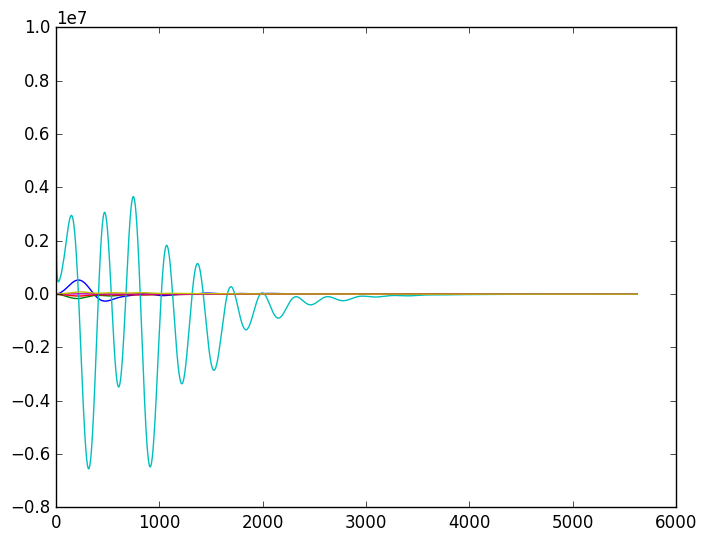

6-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x314b4c3d0>
 PyObject <matplotlib.lines.Line2D object at 0x32bcccdd0>
 PyObject <matplotlib.lines.Line2D object at 0x32bcccfd0>
 PyObject <matplotlib.lines.Line2D object at 0x32bcd7d10>
 PyObject <matplotlib.lines.Line2D object at 0x32bccc850>
 PyObject <matplotlib.lines.Line2D object at 0x32bccc7d0>

In [8]:
dϵ = 1e-12
v  = zeros(6)
v[1] = 1
X = zeros(length(bandpowers),6)
for i = 1:6
    X[:,i]   = (pico(optx + dϵ*circshift(v,i-1)) - pico(optx))/dϵ
end
plot(collect((1:length(bandpowers))).^2 .* X)

In [9]:
ell = collect(0:length(bandpowers)-1)
cldd = pico(optx) + σ² * exp(b² .* ell .* (ell + 1) ./ (8log(2)))
Σ = inv(X' * diagm(1 ./ ( (2./(2*ell+1)) .* cldd.^2)) * X)

6x6 Array{Float64,2}:
  4.51518e-8  -3.0087e-7    4.04396e-6   …   1.06184e-5    8.30099e-7 
 -3.0087e-7    4.0608e-6   -4.22228e-5      -9.01431e-5   -1.06597e-5 
  4.04396e-6  -4.22228e-5   0.00121949       0.0043485     0.000123377
  5.359e-10   -5.20205e-9   6.2312e-8        1.42756e-7    1.54297e-8 
  1.06184e-5  -9.01431e-5   0.0043485        0.0172296     0.000252468
  8.30099e-7  -1.06597e-5   0.000123377  …   0.000252468   3.30523e-5 

In [10]:
using Distributions
const lcdm_proposal_RV = MultivariateNormal(zeros(6), 0.2*Σ)
generate_lcdm_prop(lcdm_curr)  = rand(lcdm_proposal_RV) + lcdm_curr

generate_lcdm_prop (generic function with 1 method)

In [12]:
mcmc_runs     = 50_000
mcmc_thin     = 25
mcmc_burn     = 1_000
function mcmc_chain(numruns, thin, burn, lcdm_start)
    lcdmmat      = Array(Float64, 6, numruns)
    lcdmmat[:,1] = copy(lcdm_start)
    curr_ll      = loglike(lcdm_start, bandpowers, σ², b²)
    for j = 2:numruns
        lcdm_prop = generate_lcdm_prop(lcdmmat[:,j-1])
        prop_ll   = loglike(lcdm_prop, bandpowers, σ², b²)
        prob_accept = min(1.0, exp(prop_ll - curr_ll))
        if j % 250 == 1
            @show prob_accept
        end
        if rand() < prob_accept
            lcdmmat[:,j] = copy(lcdm_prop)
            curr_ll      = prop_ll
        else
            lcdmmat[:,j] = copy(lcdmmat[:, j-1])
        end
    end
    return lcdmmat[:,burn:thin:end]
end

#  ----- run the mcmc
@time lcdmmat = mcmc_chain(mcmc_runs, mcmc_thin, mcmc_burn, optx);
#@code_warntype mcmc_chain(mcmc_runs, mcmc_thin, mcmc_burn, optx);

prob_accept = 0.5431029688511336
prob_accept = 0.23683738159942963
prob_accept = 0.16543160451073463
prob_accept = 0.8733980966151758


LoadError: LoadError: InterruptException:
while loading In[12], in expression starting on line 155

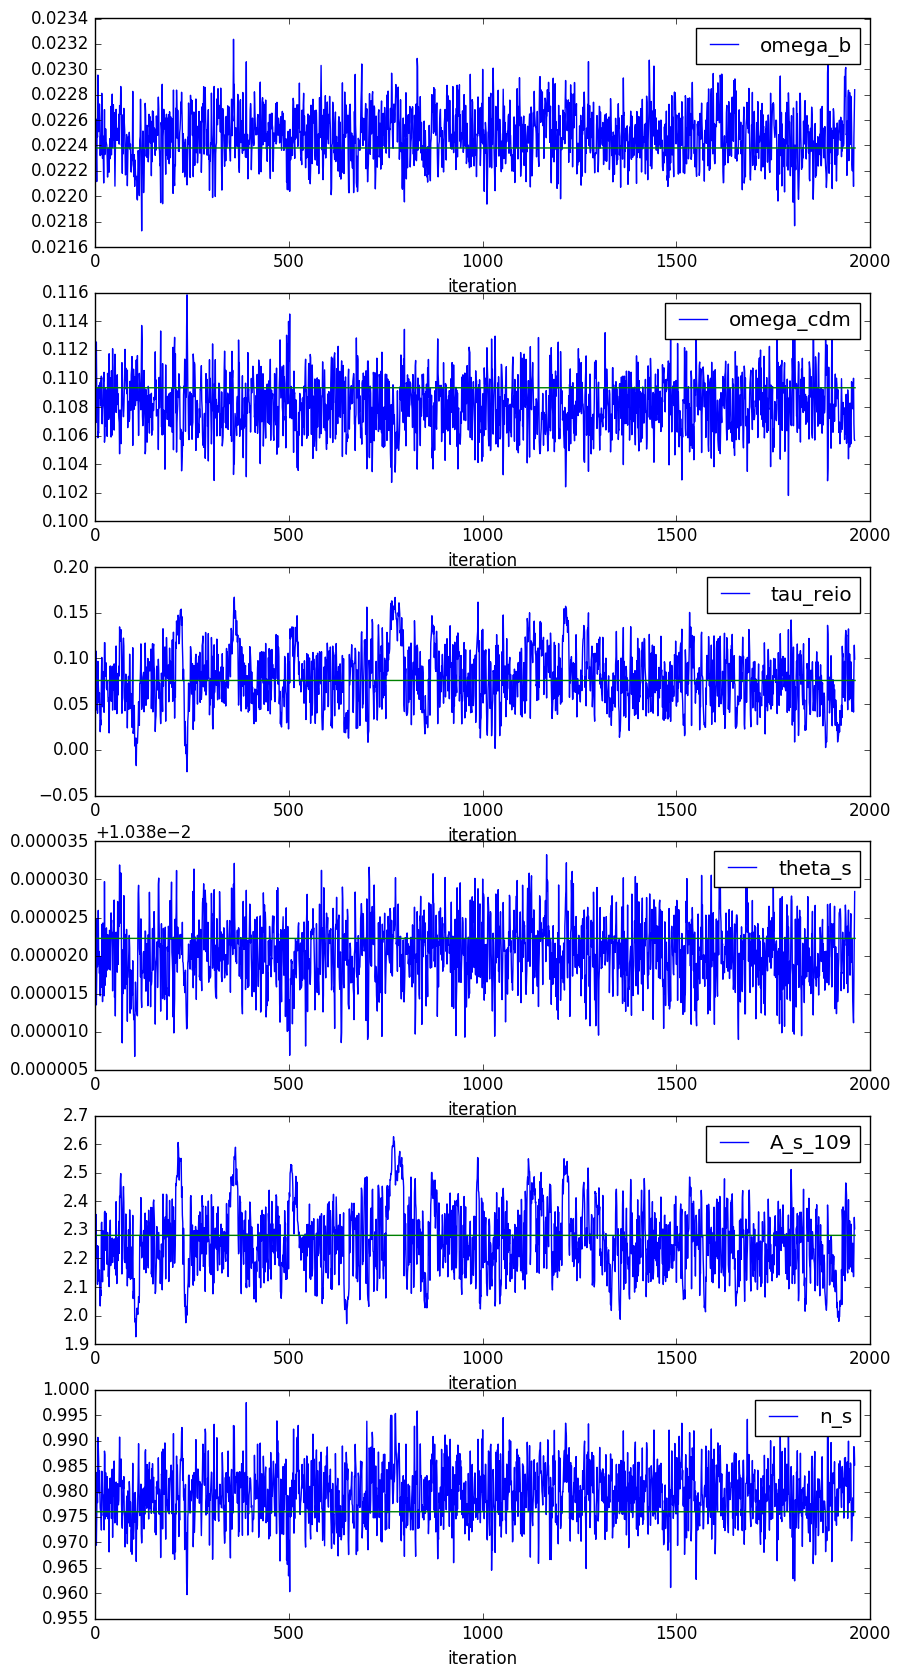

PyObject <matplotlib.legend.Legend object at 0x328d33950>

In [12]:
figure(figsize=(10,20))
itr = 1:length(lcdmmat[1,:])
index = 1:1:length(itr)
subplot(6,1,1)
plot(lcdmmat[1,index]', label = "$(names_chain[1])")
plot(itr[index], 0.0.*itr[index] + lcdm_sim_truth[1])
xlabel("iteration")
legend()
subplot(6,1,2)
plot(lcdmmat[2,index]', label = "$(names_chain[2])")
plot(itr[index], 0.0.*itr[index] + lcdm_sim_truth[2])
xlabel("iteration")
legend()
subplot(6,1,3)
plot(lcdmmat[3,index]', label = "$(names_chain[3])")
plot(itr[index], 0.0.*itr[index] + lcdm_sim_truth[3])
xlabel("iteration")
legend()
subplot(6,1,4)
plot(lcdmmat[4,index]', label = "$(names_chain[4])")
plot(itr[index], 0.0.*itr[index] + lcdm_sim_truth[4])
xlabel("iteration")
legend()
subplot(6,1,5)
plot(lcdmmat[5,index]', label = "$(names_chain[5])")
plot(itr[index], 0.0.*itr[index] + lcdm_sim_truth[5])
xlabel("iteration")
legend()
subplot(6,1,6)
plot(lcdmmat[6,index]', label = "$(names_chain[6])")
plot(itr[index], 0.0.*itr[index] + lcdm_sim_truth[6])
xlabel("iteration")
legend()

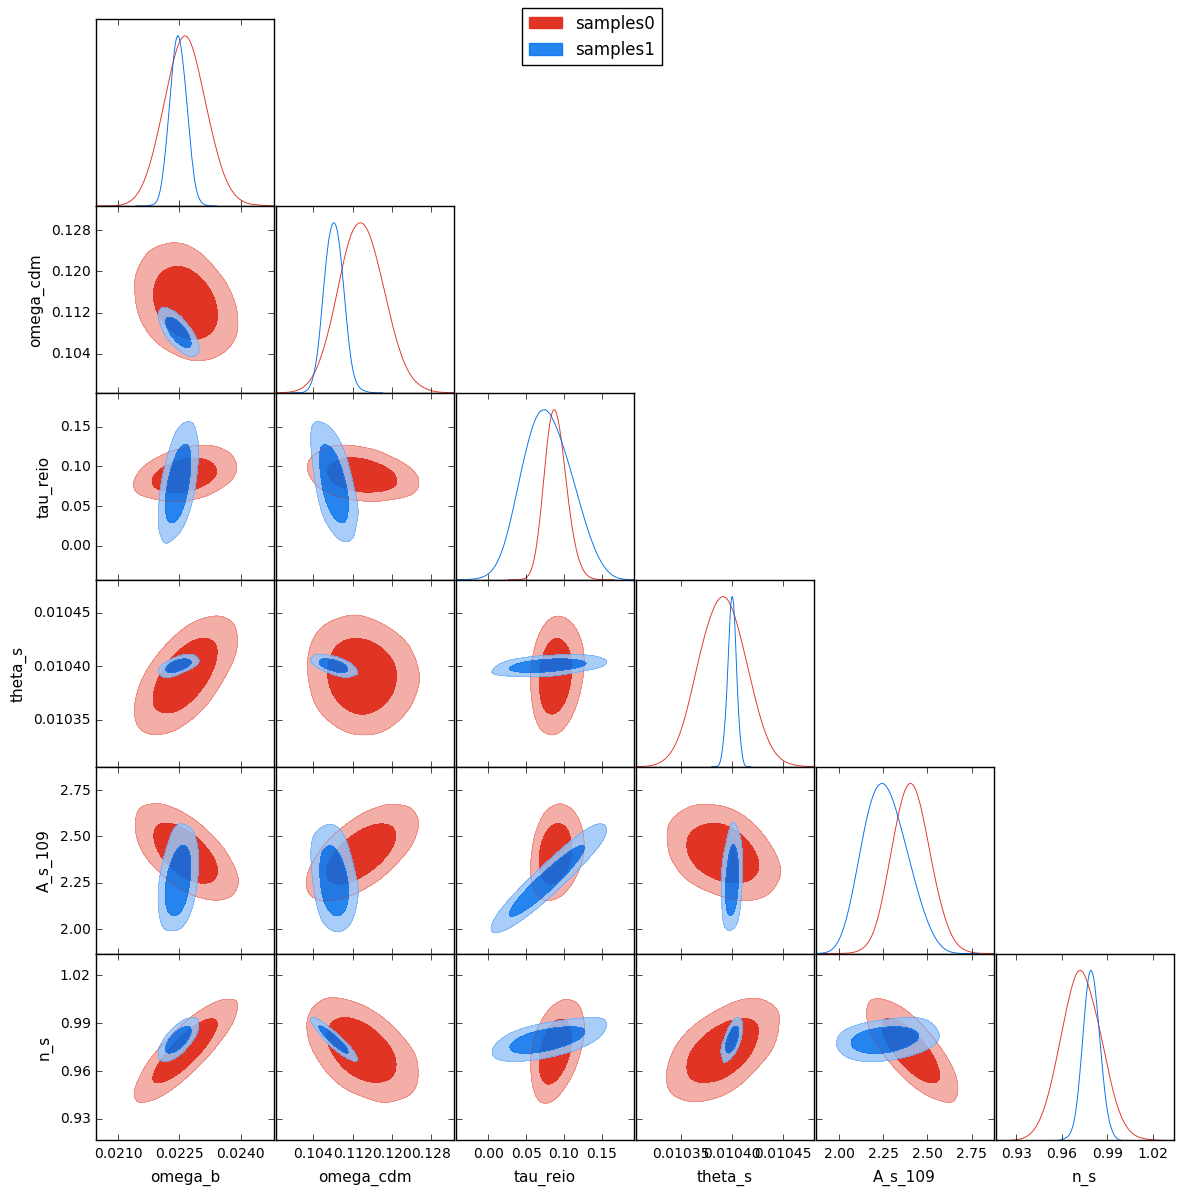

In [13]:
@pyimport getdist
@pyimport getdist.plots as plots 
samples1 = getdist.MCSamples(samples=full_chain[20_000:50_000,:] , names=names_chain)
samples2 = getdist.MCSamples(samples=lcdmmat', names=names_chain)
g = plots.getSubplotPlotter()
g[:triangle_plot]([samples1, samples2], filled=true)